In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

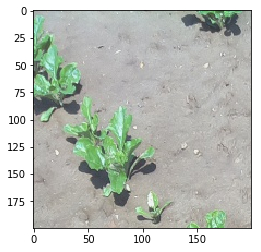

In [4]:
img_cv = cv2.imread('data/im_0.jpg')
img = img_cv[:, :, ::-1]
plt.imshow(img)

In [45]:
def ndi(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    
    NDI = 128 * ((G - R)/(G + R) + 1)
    
    return NDI.astype('uint8')

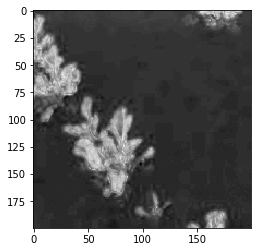

In [46]:
ndi_img = ndi(img)
plt.imshow(ndi_img, cmap='gray')

In [41]:
def exg(img):
    R = img[:, :, 0].astype(int)
    G = img[:, :, 1].astype(int)
    B = img[:, :, 2].astype(int)
    
    sum_RGB = R + G + B
    EXG = (2 * G - R - B) / sum_RGB
    
    return EXG.astype('uint8')

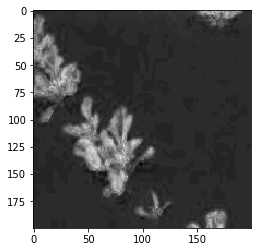

In [42]:
exg_img = exg(img)
plt.imshow(exg_img, cmap='gray')

In [43]:
def otsu_binarization(img):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

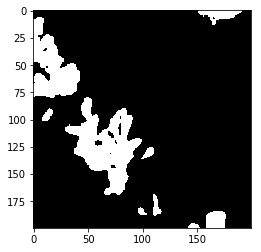

In [47]:
binary_img = otsu_binarization(exg_img)
plt.imshow(binary_img, cmap='gray')

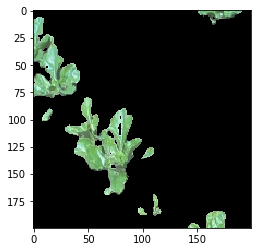

In [58]:
plant_img = np.copy(img)
plant_img[binary_img==0]=[0, 0, 0]
plt.imshow(plant_img)

In [60]:
contours, hierarchy = cv2.findContours(binary_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

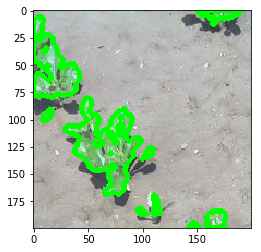

In [67]:
img2 = np.copy(img)
cv2.drawContours(img2, contours, -1, (0,255,0), 3)
plt.imshow(img2)

In [80]:
hist = np.histogram(exg_img, 256,[0,256])

(array([1.8700e+02, 3.2214e+04, 1.6810e+03, 1.3710e+03, 1.5350e+03,
        1.5110e+03, 1.0160e+03, 4.2100e+02, 6.1000e+01, 3.0000e+00]),
 array([121. , 125.1, 129.2, 133.3, 137.4, 141.5, 145.6, 149.7, 153.8,
        157.9, 162. ]),
 <a list of 10 Patch objects>)

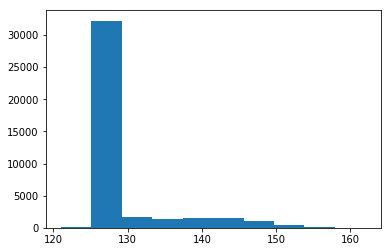

In [82]:
plt.hist(exg_img.flatten())

In [83]:
def mean_binarization(img):
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    return th3

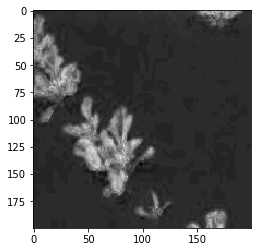

In [85]:
mean_binary_img = mean_binarization(exg_img)
plt.imshow(exg_img, cmap='gray')